In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from Dataplotting import Plotter
from importData import import_clean_police_data
import matplotlib.dates as mdates
sns.set()

In [2]:
data_all = import_clean_police_data()
# data_all.drop(columns= ["Call_answered", "Call_end", "Call_end"], inplace = True)
data_all["Total_calls"] = data_all["Answered"] +  data_all["Missed"]

In [4]:

FFF = {"Hour of day": ("H", 'getattr(data.index, "hour")', 'list(map(lambda x: f"{str(x).zfill(2)}:00", data.index.tolist()))'),
       "Day of week": ("D", 'getattr(data.index, "day_of_week")','list(map(lambda x: days[x], data.index.tolist()))'),
       "Day of month": ("D",'getattr(data.index, "day")','data.index.tolist()'),
       "Week of year": ("W",'getattr(getattr(data.index, "isocalendar")(),"week")','data.index.tolist()'),
       "Month of year": ("MS",'getattr(data.index, "month")', 'list(map(lambda x: months[x-1], data.index.tolist()))')}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

In [4]:
def plot(frequence, Year_policy, District, Call_type, Years, Fields):
    filtering = ((data_all.District.isin(District)) & (data_all.Call_type.isin(Call_type)) & (data_all.index.year.isin(Years)))
    fig, ax = plt.subplots(figsize = (10,5))
    if Year_policy == "Aggregate":
        data = data_all.loc[filtering].resample(FFF[frequence][0]).agg({"Answered" : "sum", "Missed":"sum","Total_calls": "sum", "Waiting_time": "mean", "Call_duration": "mean", "Total_time": "mean"}).copy()
        data = data.groupby(eval(FFF[frequence][1])).agg({"Answered" : "mean", "Missed":"mean", "Total_calls": "mean", "Waiting_time": "mean", "Call_duration": "mean", "Total_time": "mean"})
        for field in Fields:
            ax.plot(eval(FFF[frequence][2]), data[field], label = field.replace("_", " "))
        ax.set_ylabel("Average n. of calls", fontname= "Times New Roman", fontsize = 16, labelpad = 6)
        ax.set_title(f"Average number of calls - {frequence}", fontname= "Times New Roman", fontsize = 18, pad = 10)
    elif Year_policy == "Separate":
        data_agg = data_all.loc[filtering].resample(FFF[frequence][0]).agg({"Answered" : "sum", "Missed":"sum","Total_calls": "sum", "Waiting_time": "mean", "Call_duration": "mean", "Total_time": "mean"}).copy()
        for y in Years:
            data = data_agg.loc[f"{y}"].copy()
            data = data.groupby(eval(FFF[frequence][1])).agg({"Answered" : "mean", "Missed":"mean", "Total_calls": "mean", "Waiting_time": "mean", "Call_duration": "mean", "Total_time": "mean"})
            for field in Fields:
                ax.plot(eval(FFF[frequence][2]), data[field], label = f"{y} - {field}".replace("_", " "))
        ax.set_ylabel("n. of calls", fontname= "Times New Roman", fontsize = 16, labelpad = 6)
        ax.set_title(f"Number of calls - {frequence}", fontname= "Times New Roman", fontsize = 18, pad = 10)
    ax.set_xlabel(f"{frequence}", fontname= "Times New Roman", fontsize = 16, labelpad = 6)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation = 45)
    plt.show()

In [ ]:
# missed calls : not answered and waiting time 3 seconds(), 4pm 7-pm for 02800 folder 
# focus on sor ost 5-10 plots 
# focus only the direkte OPS 
# for the forecasting not aggregate the calls, different models 

In [ ]:
plot(frequence = "Day of month",
Year_policy = "Aggregate",
District = {"203 Innlandet"},
Call_type = {"112"},
Years = {2018, 2019, 2020},
Fields = {"Total_calls", "Answered", "Missed"})

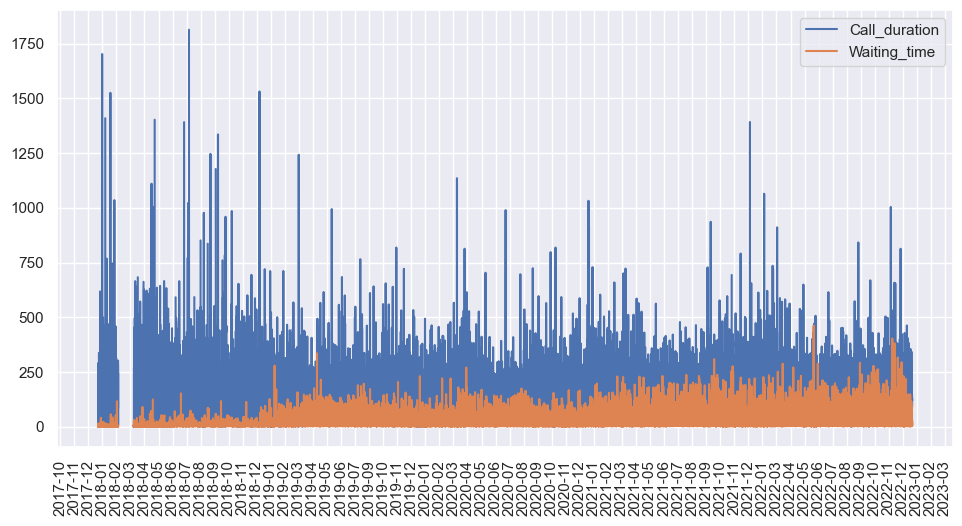

In [8]:
F = {"Hourly":1, "Daily": 24, "Weekly": 24*7*4, "Monthly":24*7*4}
FF = {"Weekly": "%Y-W%W", "Monthly": "%Y-%m"}

def plot_summary(frequence, District, Call_type, Years, Fields):
    filtering = ((data_all.District.isin(District)) & (data_all.Call_type.isin(Call_type)) & (data_all.index.year.isin(Years)))
    data = data_all.loc[filtering].resample("H").agg({"Answered" : "sum", "Missed":"sum","Total_calls": "sum", "Waiting_time": "mean", "Call_duration": "mean", "Total_time": "mean"}).copy()
    fig, ax = plt.subplots(figsize = (10,5))
    for field in Fields:
        if field in {"Waiting_time", "Call_duration", "Total_time"}:
            ax.plot(data[field], label = f"{field}")
        else:
            ax.plot(data[field].rolling(F[frequence]).sum(), label = f"{field}")
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=27*7*4)) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter(FF[frequence]))    
    fig.tight_layout()
    plt.xticks(rotation = 90)
    plt.grid(True)
    plt.legend()
    plt.show()
plot_summary(frequence = "Monthly",
District = {"204 Sør-Øst"},
Call_type = {"02800", "112"},
Years = {2018, 2019, 2020, 2021, 2022},
Fields = {"Call_duration", "Waiting_time"})

In [ ]:
field = "Total_calls"
District = {"203 Innlandet"}
Call_type = {"112"}
Years = {2020,2021}

filtering = ((data_all.District.isin(District)) & (data_all.Call_type.isin(Call_type)) & (data_all.index.year.isin(Years)))
data = data_all.loc[filtering].resample("H").agg({"Answered" : "sum", "Missed":"sum","Total_calls": "sum", "Waiting_time": "mean", "Call_duration": "mean", "Total_time": "mean"}).copy(deep = True)
data = pd.DataFrame(data[field])
data["DOW"] = data.index.day_of_week
data["Hour"] = data.index.hour
data = data.groupby(["Hour", "DOW"], as_index= False).mean()
data = data.pivot(index = "DOW", columns="Hour", values= field)
data.columns = [f"{str(x).zfill(2)}:00" for x in data.columns]
data.index = [["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][x] for x in data.index]
fig, ax = plt.subplots(figsize = (18,7))
ax = sns.heatmap(data, annot = True, fmt=".0f", cmap= sns.color_palette("YlOrBr", as_cmap=True))
ax.tick_params(labelsize=16)
plt.xticks(rotation = 425)
plt.show()


In [59]:
import numpy as np 


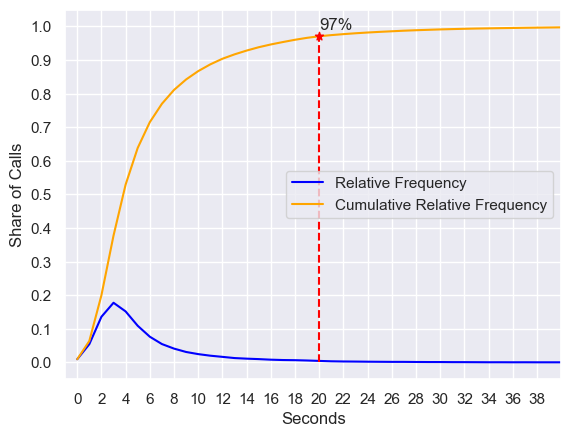

,Frequency,Comulative_Frequency,Relative_Frequency,Relative_Cumulative_Frequency
Waiting_time,,,,
0.0,1749,1749,0.009485,0.009485
1.0,10032,11781,0.054406,0.063891
2.0,25059,36840,0.135901,0.199792
3.0,32756,69596,0.177643,0.377435
4.0,28007,97603,0.151888,0.529323
...,...,...,...,...
127.0,1,184388,0.000005,0.999978
141.0,1,184389,0.000005,0.999984
145.0,1,184390,0.000005,0.999989


In [93]:
District = {"204 Sør-Øst"}
Years = {2020,2021}

filtering = ((data_all.District.isin(District)) & (data_all.Call_type == "112") & (data_all.index.year.isin(Years) & ( data_all.Answered == 1)))
data = data_all.loc[filtering].copy(deep = True)
data = data.groupby("Waiting_time").agg({"Answered" : "sum"}).rename(columns = {"Answered": "Frequency"})
data["Comulative_Frequency"] = data["Frequency"].cumsum()
data["Relative_Frequency"] = data["Frequency"] / data["Frequency"].sum()
data["Relative_Cumulative_Frequency"] = data["Relative_Frequency"].cumsum()
plt.plot(data["Relative_Frequency"], color = "blue", label = "Relative Frequency")
plt.plot(data["Relative_Cumulative_Frequency"], color = "orange", label = "Cumulative Relative Frequency")
plt.vlines(x = 20, ymax= data.loc[20,"Relative_Cumulative_Frequency"], ymin = 0, color = "red", linestyles= "dashed")
plt.scatter(20,data.loc[20,"Relative_Cumulative_Frequency"], color = "red", marker= "*", zorder = 3)
plt.text(20,data.loc[20,"Relative_Cumulative_Frequency"] + 0.01,f'{int(data.loc[20,"Relative_Cumulative_Frequency"]*100)}%',verticalalignment='bottom', )
plt.xticks(range(0,40,2))
plt.yticks(np.linspace(0,1,11,endpoint=True))
plt.xlim((-1,40))
plt.ylabel("Share of Calls")
plt.xlabel("Seconds")
plt.legend()
plt.show()
data

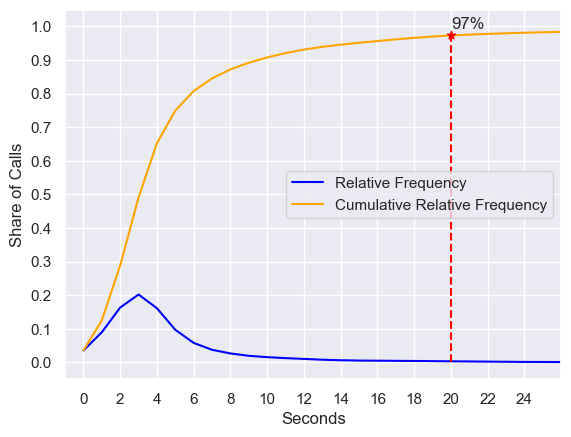

In [104]:
District =  {"203 Innlandet"}#{"204 Sør-Øst"}
Years = {2022,2021, 2020,  2019, 2018}
s = 20
lower_bound = 0
upper_bound = 25

filtering = ((data_all.District.isin(District)) & (data_all.Call_type == "112") & (data_all.index.year.isin(Years)))# & ( data_all.Answered == 1)))
data = data_all.loc[filtering].copy(deep = True)
data = data.groupby("Waiting_time").agg({"Waiting_time" : "size"}).rename(columns = {"Waiting_time": "Frequency"})
data["Comulative_Frequency"] = data["Frequency"].cumsum()
data["Relative_Frequency"] = data["Frequency"] / data["Frequency"].sum()
data["Relative_Cumulative_Frequency"] = data["Relative_Frequency"].cumsum()
plt.plot(data["Relative_Frequency"], color = "blue", label = "Relative Frequency")
plt.plot(data["Relative_Cumulative_Frequency"], color = "orange", label = "Cumulative Relative Frequency")
plt.vlines(x = s, ymax= data.loc[s,"Relative_Cumulative_Frequency"], ymin = 0, color = "red", linestyles= "dashed")
plt.scatter(s,data.loc[s,"Relative_Cumulative_Frequency"], color = "red", marker= "*", zorder = 3)
plt.text(s,data.loc[s,"Relative_Cumulative_Frequency"] + 0.01,f'{int(data.loc[s,"Relative_Cumulative_Frequency"]*100)}%',verticalalignment='bottom', )
plt.xticks(range(lower_bound,upper_bound+1,2))
plt.yticks(np.linspace(0,1,11,endpoint=True))
plt.xlim((lower_bound-1,upper_bound+1))
plt.ylabel("Share of Calls")
plt.xlabel("Seconds")
plt.legend()
plt.show()

In [92]:
data

,Frequency,Comulative_Frequency,Relative_Frequency,Relative_Cumulative_Frequency
Waiting_time,,,,
0.0,6201,6201,0.028503,0.028503
1.0,18083,24284,0.083118,0.111621
2.0,31096,55380,0.142933,0.254554
3.0,36721,92101,0.168788,0.423342
4.0,30974,123075,0.142372,0.565714
...,...,...,...,...
127.0,1,217553,0.000005,0.999982
141.0,1,217554,0.000005,0.999986
145.0,1,217555,0.000005,0.999991
